In [2]:
### Load necessary libraries ###
import glob
import os
import librosa
import librosa.display

import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

In [7]:
# files = ['UrbanSounds8K/audio/fold1\\105415-2-0-19.wav', 'UrbanSounds8K/audio/fold1\\105415-2-0-21.wav']
# segment_log_specgrams, segment_labels = [], []

# for fn in files:
#     start = 0
#     end = 512*40
#     bands = 60

#     sound_clip,sr = librosa.load(fn)
#     signal = sound_clip[start:end]
#     label = int(fn.split('/')[2].split('-')[1])

#     '''
#     This is new
#     '''
#     melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
#     fig, ax = plt.subplots()
#     S_dB = librosa.amplitude_to_db(melspec, ref=np.max)
#     logspec = S_dB.flatten()[:, np.newaxis]
#     img = librosa.display.specshow(logspec.reshape(np.shape(S_dB)), x_axis='time',
#                             y_axis='mel', sr=sr,
#                             fmax=8000, ax=ax)

#     fig.colorbar(img, ax=ax, format='%+2.0f dB')
#     ax.set(title='Mel-frequency spectrogram')
#     segment_log_specgrams.append(logspec)
#     segment_labels.append(label)
#     print(np.shape(logspec))


# # np.shape(segment_log_specgrams) = (2, 1, 2460)


NameError: name 'plt' is not defined

In [14]:
### Define helper functions ###
def extract_features(parent_dir,sub_dirs,file_ext="*.wav",
                     bands=60,frames=41):
    '''
    '''

    def _windows(data, window_size):
        start = 0
        while start < len(data):
            yield int(start), int(start + window_size)
            start += (window_size // 2)
            
    window_size = 512 * (frames - 1)
    features, labels = [], []

    for fn in glob.glob(os.path.join(parent_dir, sub_dirs, file_ext)):

        # Load data with label
        segment_log_specgrams, segment_labels = [], []
        sound_clip,sr = librosa.load(fn)
        label = int(fn.split('/')[2].split('-')[1])

        # For each generator term
        for (start,end) in _windows(sound_clip,window_size):

            # If the window size is correct 
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]

                melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
                S_dB = librosa.amplitude_to_db(melspec, ref=np.max)
                logspec = S_dB.flatten()[:, np.newaxis]

                # melspec = librosa.feature.melspectrogram(signal,n_mels=bands)
                # logspec = librosa.amplitude_to_db(melspec)
                # logspec = logspec.T.flatten()[:, np.newaxis].T

                segment_log_specgrams.append(logspec)
                segment_labels.append(label)
                # np.shape(segment_log_specgrams) = (N, 1, 2460) = (N, 1, BxF) 
                # where 2460 is 60 bands x 41 frames 

        # Reshape to NxBxF
        segment_log_specgrams = np.asarray(segment_log_specgrams).reshape(
            len(segment_log_specgrams),bands,frames,1)

        # Prep 2nd dimension for delta - add zero array to form (NxBxFx2)
        segment_features = np.concatenate((segment_log_specgrams, np.zeros(
            np.shape(segment_log_specgrams))), axis=3)
        
        # Put delta of zero-th dim to first dim
        for i in range(len(segment_features)): 
            segment_features[i, :, :, 1] = librosa.feature.delta(
                segment_features[i, :, :, 0])
        
        # Append if not empty segment
        if len(segment_features) > 0:  
            features.append(segment_features)
            labels.append(segment_labels)

    return features, labels

In [15]:
# # Pre-process and extract feature from the data
parent_dir = 'UrbanSounds8K/audio/'
save_dir = "UrbanSounds8K/processed/"
folds = sub_dirs = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])

for sub_dir in sub_dirs:
    features, labels = extract_features(parent_dir,sub_dir)
    np.savez("{0}{1}".format(save_dir, sub_dir), 
             features=features, 
             labels=labels)
    print("Completed: ", sub_dir)

C:\ProgramData\Miniconda3\envs\usc39\lib\site-packages\numpy\lib\npyio.py:719: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


Completed:  fold1
Completed:  fold2
Completed:  fold3
Completed:  fold4
Completed:  fold5
Completed:  fold6
Completed:  fold7
Completed:  fold8
Completed:  fold9
Completed:  fold10


In [23]:
import tensorflow as tf
import numpy as np
path = "./UrbanSounds8K/processed_vgg/fold1.npz"
with np.load(path, allow_pickle=True) as data:
#   train_examples = tf.convert_to_tensor(data['features'])
#   train_labels = tf.convert_to_tensor(data['labels'])
  
  train_examples = np.concatenate(data["features"], axis=0) 
  # train_labels = data['labels']

# train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))

tf.convert_to_tensor(train_examples)
# print(tf.shape())


<tf.Tensor: shape=(3857, 1, 128), dtype=float32, numpy=
array([[[-0.25722322, -0.17572212, -0.1421693 , ..., -0.12204722,
          0.29442686, -0.21242645]],

       [[-0.17759523, -0.194866  , -0.00542137, ..., -0.09677908,
          0.26171687, -0.13093251]],

       [[-0.13779649,  0.10271829,  0.06871425, ...,  0.45329353,
          0.07438368, -0.27341098]],

       ...,

       [[-0.8549845 ,  0.46027777, -0.10388809, ..., -1.6611685 ,
         -0.49435228,  1.6785727 ]],

       [[-0.45216414,  0.36752474, -0.12205461, ..., -0.9714166 ,
         -0.11862539,  0.8683667 ]],

       [[-0.31338122,  0.23467936, -0.23766047, ..., -1.1122041 ,
         -0.16708903,  0.590395  ]]], dtype=float32)>

In [7]:
# # Pre-process and extract feature from the data
# parent_dir = 'UrbanSounds8K/audio/'
# save_dir = "UrbanSounds8K/processed/"
# folds = sub_dirs = np.array(['fold1','fold2','fold3','fold4',
#                   'fold5','fold6','fold7','fold8',
#                   'fold9','fold10'])
# for sub_dir in sub_dirs:
#     features, labels = extract_features(parent_dir,sub_dir)
#     np.savez("{0}{1}".format(save_dir, sub_dir), 
#              features=features, 
#              labels=labels)

In [1]:
### Define convolutional network architecture ###
def get_network():
    num_filters = [24,32,64,128] 
    pool_size = (2, 2) 
    kernel_size = (3, 3)  
    input_shape = (60, 41, 2)
    num_classes = 10
    keras.backend.clear_session()
    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(24, kernel_size,
                padding="same", input_shape=input_shape))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Conv2D(32, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    
    model.add(keras.layers.Conv2D(64, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    
    model.add(keras.layers.Conv2D(128, kernel_size,
                                  padding="same"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))  

    model.add(keras.layers.GlobalMaxPooling2D())
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dense(num_classes, activation="softmax"))

    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
        loss=keras.losses.SparseCategoricalCrossentropy(), 
        metrics=["accuracy"])
        
    return model

model = get_network()
model.summary()

NameError: name 'keras' is not defined

In [3]:
### Train and evaluate via 10-Folds cross-validation ###
accuracies = []
folds = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])
load_dir = "UrbanSounds8K/processed/"
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(folds):
    x_train, y_train = [], []
    for ind in train_index:
        # read features or segments of an audio file
        train_data = np.load("{0}/{1}.npz".format(load_dir,folds[ind]), 
                       allow_pickle=True)
        # for training stack all the segments so that they are treated as an example/instance
        features = np.concatenate(train_data["features"], axis=0) 
        labels = np.concatenate(train_data["labels"], axis=0)
        x_train.append(features)
        y_train.append(labels)
    # stack x,y pairs of all training folds 
    x_train = np.concatenate(x_train, axis = 0).astype(np.float32)
    y_train = np.concatenate(y_train, axis = 0).astype(np.float32)
    
    # for testing we will make predictions on each segment and average them to 
    # produce single label for an entire sound clip.
    test_data = np.load("{0}/{1}.npz".format(load_dir,
                   folds[test_index][0]), allow_pickle=True)
    x_test = test_data["features"]
    y_test = test_data["labels"]

    model = get_network()
    model.fit(x_train, y_train, epochs = 50, batch_size = 64, verbose = 1)
    
    # evaluate on test set/fold
    y_true, y_pred = [], []
    for x, y in zip(x_test, y_test):
        # average predictions over segments of a sound clip
        avg_p = np.argmax(np.mean(model.predict(x), axis = 0))
        y_pred.append(avg_p) 
        # pick single label via np.unique for a sound clip
        y_true.append(np.unique(y)[0]) 
    accuracies.append(accuracy_score(y_true, y_pred))    
    print("Fold n accuracy: {0}".format(accuracy_score(y_true, y_pred)))
    
print("Average 10 Folds Accuracy: {0}".format(np.mean(accuracies)))

NameError: name 'get_network' is not defined

In [16]:
accuracies = []
folds = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])
load_dir = "UrbanSounds8K/processed/"
train_data = np.load("{0}/{1}.npz".format(load_dir,folds[3]), 
                        allow_pickle=True)
features = np.concatenate(train_data["features"], axis=0) 
labels = np.concatenate(train_data["labels"], axis=0) 


In [5]:
test_index[0]

0

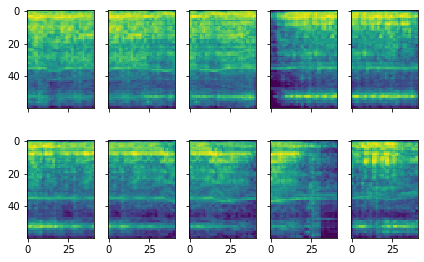

In [41]:
# Plotting functions
import matplotlib.pyplot as plt
start = 2500

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True, )
# fig.set_size_inches(10, 20)
ax = ax.flatten()
for i in range(10):
    mfcc = features[start+i,:,:,0]
    
    # Display in feature form (not flipped, by 60 bands)
    img = ax[i].imshow(mfcc, interpolation='nearest')
    
    # Display in true spectrogram (flipped, by frequency )
    # img = librosa.display.specshow(mfcc, x_axis='time', y_axis='mel', ax=ax[i])
    # ax[i].imshow(img, interpolation='nearest')

plt.tight_layout()



In [9]:
# Understanding the kf.split functions
accuracies = []
folds = np.array(['fold1','fold2','fold3','fold4',
                  'fold5','fold6','fold7','fold8',
                  'fold9','fold10'])
load_dir = "UrbanSounds8K/processed/"
kf = KFold(n_splits=10)
for train_index, test_index in kf.split(folds):
    for ind in train_index:
        print(test_index, ind)
        # # read features or segments of an audio file
        train_data = np.load("{0}/{1}.npz".format(load_dir,folds[ind]), 
                        allow_pickle=True)
        # # for training stack all the segments so that they are treated as an example/instance
        # features = np.concatenate(train_data["features"], axis=0) 
        # labels = np.concatenate(train_data["labels"], axis=0)
        # x_train.append(features)
        # y_train.append(labels)

[0] 1
[0] 2
[0] 3
[0] 4
[0] 5
[0] 6
[0] 7
[0] 8
[0] 9
[1] 0
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[2] 0
[2] 1
[2] 3
[2] 4
[2] 5
[2] 6
[2] 7
[2] 8
[2] 9
[3] 0
[3] 1
[3] 2
[3] 4
[3] 5
[3] 6
[3] 7
[3] 8
[3] 9
[4] 0
[4] 1
[4] 2
[4] 3
[4] 5
[4] 6
[4] 7
[4] 8
[4] 9
[5] 0
[5] 1
[5] 2
[5] 3
[5] 4
[5] 6
[5] 7
[5] 8
[5] 9
[6] 0
[6] 1
[6] 2
[6] 3
[6] 4
[6] 5
[6] 7
[6] 8
[6] 9
[7] 0
[7] 1
[7] 2
[7] 3
[7] 4
[7] 5
[7] 6
[7] 8
[7] 9
[8] 0
[8] 1
[8] 2
[8] 3
[8] 4
[8] 5
[8] 6
[8] 7
[8] 9
[9] 0
[9] 1
[9] 2
[9] 3
[9] 4
[9] 5
[9] 6
[9] 7
[9] 8
